In [2]:
# CRISP-DM Project: Employee Attrition Prediction
# Dataset: IBM HR Analytics Employee Attrition Dataset
# Business Goal: Predict which employees are likely to leave the company

In [3]:
# Cell 1: Setup and Data Loading

# Install required library
!pip install imblearn

# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                             roc_auc_score, roc_curve, precision_recall_curve)
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("=" * 80)
print("PHASE 1: BUSINESS UNDERSTANDING")
print("=" * 80)
print("\nBusiness Problem:")
print("- High employee turnover costs companies significantly in recruitment,")
print("  training, and lost productivity.")
print("- Goal: Predict which employees are at risk of leaving (Attrition)")
print("- Success Metric: High Recall for 'Attrition=Yes' to identify at-risk employees")
print("\n" + "=" * 80)

# Load the dataset
# Download from: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset
url = "https://raw.githubusercontent.com/IBM/employee-attrition-aif360/master/data/emp_attrition.csv"

try:
    df = pd.read_csv(url)
    print("\n✅ Data loaded successfully!")
    print(f"Dataset shape: {df.shape}")
    print(f"\nFirst few rows:")
    print(df.head())
except Exception as e:
    print(f"❌ Error loading data: {e}")
    print("Please download the dataset manually and update the path.")


PHASE 1: BUSINESS UNDERSTANDING

Business Problem:
- High employee turnover costs companies significantly in recruitment,
  training, and lost productivity.
- Goal: Predict which employees are at risk of leaving (Attrition)
- Success Metric: High Recall for 'Attrition=Yes' to identify at-risk employees


✅ Data loaded successfully!
Dataset shape: (1470, 35)

First few rows:
   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 


PHASE 2: DATA UNDERSTANDING

--- Dataset Info ---
Number of rows: 1470
Number of columns: 35

Column names and types:
Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
Relati

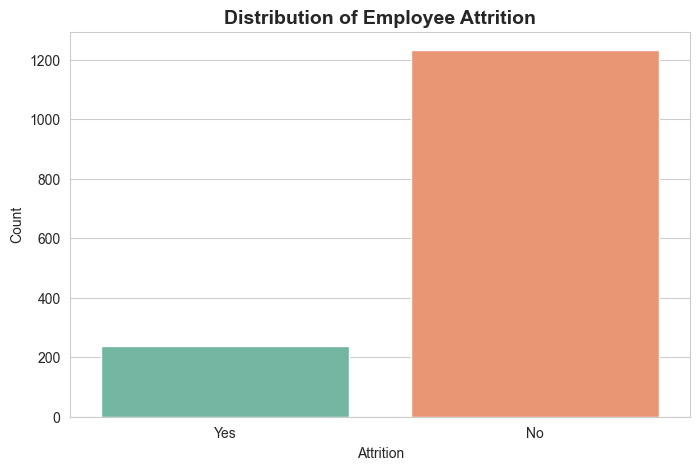


--- Exploring Key Relationships ---
Numeric columns: 26


In [4]:
# Data Understanding (Exploratory Data Analysis)

print("\n" + "=" * 80)
print("PHASE 2: DATA UNDERSTANDING")
print("=" * 80)

print("\n--- Dataset Info ---")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print(f"\nColumn names and types:")
print(df.dtypes)

print("\n--- Target Variable Distribution ---")
print(df['Attrition'].value_counts())
print(f"\nAttrition Rate: {df['Attrition'].value_counts(normalize=True)['Yes']*100:.2f}%")

# Check for missing values
print("\n--- Missing Values ---")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("✅ No missing values found!")
else:
    print(missing[missing > 0])

# Statistical summary
print("\n--- Statistical Summary (Numerical Features) ---")
print(df.describe())

# Visualize target variable
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Attrition', palette='Set2')
plt.title('Distribution of Employee Attrition', fontsize=14, fontweight='bold')
plt.xlabel('Attrition')
plt.ylabel('Count')
plt.show()

# Correlation analysis for key numeric features
print("\n--- Exploring Key Relationships ---")
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numeric columns: {len(numeric_cols)}")



In [5]:
# Cell 3: Data Preparation (Cleaning & Feature Engineering)

print("\n" + "=" * 80)
print("PHASE 3: DATA PREPARATION")
print("=" * 80)

# Create a copy for processing
df_processed = df.copy()

# 1. Handle target variable - convert to binary
print("\n--- Step 1: Target Variable Encoding ---")
df_processed['Attrition'] = df_processed['Attrition'].map({'Yes': 1, 'No': 0})
print("✅ Attrition encoded: Yes=1, No=0")

# 2. Drop unnecessary columns
# (EmployeeCount, StandardHours, Over18 are constants)
cols_to_drop = ['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber']
cols_to_drop = [col for col in cols_to_drop if col in df_processed.columns]
df_processed = df_processed.drop(cols_to_drop, axis=1)
print(f"\n--- Step 2: Dropped {len(cols_to_drop)} constant/ID columns ---")

# 3. Feature Engineering
print("\n--- Step 3: Feature Engineering ---")

# Create new meaningful features
df_processed['YearsPerPromotion'] = (df_processed['YearsSinceLastPromotion'] + 1) / \
                                     (df_processed['YearsAtCompany'] + 1)
df_processed['YearsWithManager'] = df_processed['YearsAtCompany'] - \
                                   df_processed['YearsWithCurrManager']
df_processed['TotalSatisfaction'] = (df_processed['EnvironmentSatisfaction'] + 
                                     df_processed['JobSatisfaction'] + 
                                     df_processed['RelationshipSatisfaction']) / 3
df_processed['WorkLifeBalance_Score'] = df_processed['WorkLifeBalance'] * \
                                        (5 - df_processed['JobInvolvement'])

print("✅ Created new features:")
print("   - YearsPerPromotion")
print("   - YearsWithManager")
print("   - TotalSatisfaction")
print("   - WorkLifeBalance_Score")

# 4. Encode categorical variables
print("\n--- Step 4: Encoding Categorical Variables ---")

# Identify categorical columns
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns found: {categorical_cols}")

# Label encoding for ordinal/binary features
label_encoder = LabelEncoder()
for col in categorical_cols:
    df_processed[col] = label_encoder.fit_transform(df_processed[col])

print("✅ All categorical variables encoded")

# 5. Identify feature types for preprocessing
numeric_features = df_processed.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove('Attrition')  # Remove target

print(f"\n--- Final Feature Count ---")
print(f"Total features: {len(numeric_features)}")
print(f"Target variable: Attrition")

# Display processed data sample
print("\n--- Processed Data Sample ---")
print(df_processed.head())



PHASE 3: DATA PREPARATION

--- Step 1: Target Variable Encoding ---
✅ Attrition encoded: Yes=1, No=0

--- Step 2: Dropped 4 constant/ID columns ---

--- Step 3: Feature Engineering ---
✅ Created new features:
   - YearsPerPromotion
   - YearsWithManager
   - TotalSatisfaction
   - WorkLifeBalance_Score

--- Step 4: Encoding Categorical Variables ---
Categorical columns found: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
✅ All categorical variables encoded

--- Final Feature Count ---
Total features: 34
Target variable: Attrition

--- Processed Data Sample ---
   Age  Attrition  BusinessTravel  DailyRate  Department  DistanceFromHome  \
0   41          1               2       1102           2                 1   
1   49          0               1        279           1                 8   
2   37          1               2       1373           1                 2   
3   33          0               1       1392           1         

In [6]:
# Data Splitting and Preprocessing

print("\n" + "=" * 80)
print("PHASE 4: MODELING - Data Splitting & Preprocessing")
print("=" * 80)

# Separate features and target
X = df_processed.drop('Attrition', axis=1)
y = df_processed['Attrition']

print(f"\n--- Original Distribution ---")
print(y.value_counts(normalize=True))

# Split data (80-20 split with stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n--- Data Split ---")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("\n✅ Features scaled using StandardScaler")

# Handle class imbalance with SMOTE
print("\n--- Handling Class Imbalance with SMOTE ---")
print(f"Before SMOTE - Training set distribution:")
print(y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"\nAfter SMOTE - Training set distribution:")
print(pd.Series(y_train_resampled).value_counts())
print("✅ Classes balanced!")


PHASE 4: MODELING - Data Splitting & Preprocessing

--- Original Distribution ---
Attrition
0    0.838776
1    0.161224
Name: proportion, dtype: float64

--- Data Split ---
Training set: 1176 samples
Testing set: 294 samples

✅ Features scaled using StandardScaler

--- Handling Class Imbalance with SMOTE ---
Before SMOTE - Training set distribution:
Attrition
0    986
1    190
Name: count, dtype: int64

After SMOTE - Training set distribution:
Attrition
0    986
1    986
Name: count, dtype: int64
✅ Classes balanced!


In [7]:
# Model Training

print("\n" + "=" * 80)
print("PHASE 4: MODELING - Training Multiple Models")
print("=" * 80)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42, max_depth=10),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Train all models
trained_models = {}
print("\n--- Training Models ---")
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_resampled, y_train_resampled)
    trained_models[name] = model
    print(f"✅ {name} trained successfully")

print("\n✅ All models trained!")



PHASE 4: MODELING - Training Multiple Models

--- Training Models ---
Training Logistic Regression...
✅ Logistic Regression trained successfully
Training Decision Tree...
✅ Decision Tree trained successfully
Training Random Forest...
✅ Random Forest trained successfully
Training Gradient Boosting...
✅ Gradient Boosting trained successfully

✅ All models trained!



PHASE 5: EVALUATION

MODEL: Logistic Regression

Accuracy: 0.7653
ROC-AUC Score: 0.8081


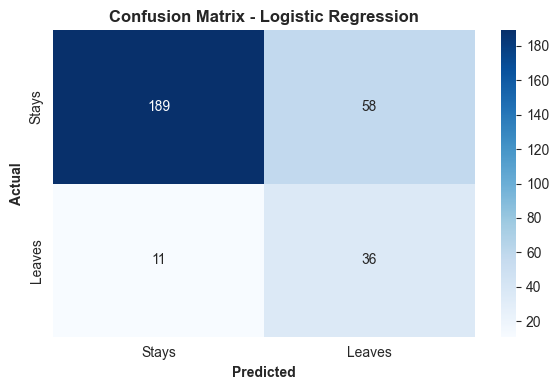


Classification Report:
              precision    recall  f1-score   support

   Stays (0)       0.94      0.77      0.85       247
  Leaves (1)       0.38      0.77      0.51        47

    accuracy                           0.77       294
   macro avg       0.66      0.77      0.68       294
weighted avg       0.86      0.77      0.79       294


MODEL: Decision Tree

Accuracy: 0.7789
ROC-AUC Score: 0.6009


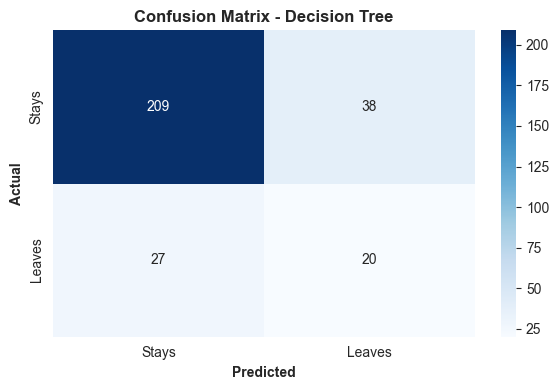


Classification Report:
              precision    recall  f1-score   support

   Stays (0)       0.89      0.85      0.87       247
  Leaves (1)       0.34      0.43      0.38        47

    accuracy                           0.78       294
   macro avg       0.62      0.64      0.62       294
weighted avg       0.80      0.78      0.79       294


MODEL: Random Forest

Accuracy: 0.8469
ROC-AUC Score: 0.7956


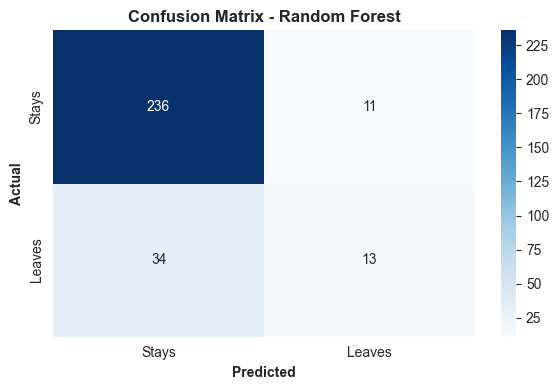


Classification Report:
              precision    recall  f1-score   support

   Stays (0)       0.87      0.96      0.91       247
  Leaves (1)       0.54      0.28      0.37        47

    accuracy                           0.85       294
   macro avg       0.71      0.62      0.64       294
weighted avg       0.82      0.85      0.83       294


MODEL: Gradient Boosting

Accuracy: 0.8401
ROC-AUC Score: 0.7939


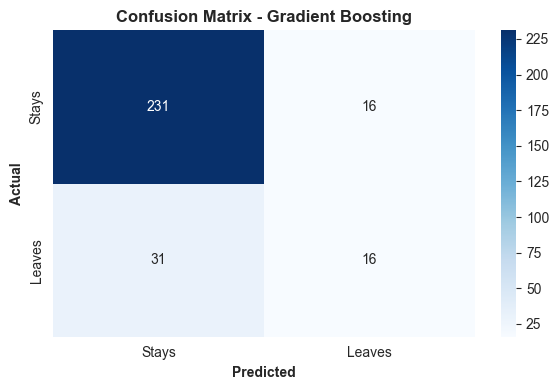


Classification Report:
              precision    recall  f1-score   support

   Stays (0)       0.88      0.94      0.91       247
  Leaves (1)       0.50      0.34      0.41        47

    accuracy                           0.84       294
   macro avg       0.69      0.64      0.66       294
weighted avg       0.82      0.84      0.83       294



In [8]:
# Cell 6: Model Evaluation

print("\n" + "=" * 80)
print("PHASE 5: EVALUATION")
print("=" * 80)

# Store results for comparison
results = []

for name, model in trained_models.items():
    print(f"\n{'='*60}")
    print(f"MODEL: {name}")
    print('='*60)
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Stays', 'Leaves'],
                yticklabels=['Stays', 'Leaves'])
    plt.xlabel('Predicted', fontweight='bold')
    plt.ylabel('Actual', fontweight='bold')
    plt.title(f'Confusion Matrix - {name}', fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Classification Report
    print("\nClassification Report:")
    report = classification_report(y_test, y_pred, 
                                   target_names=['Stays (0)', 'Leaves (1)'],
                                   output_dict=True)
    print(classification_report(y_test, y_pred, 
                               target_names=['Stays (0)', 'Leaves (1)']))
    
    # Store results
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'ROC-AUC': roc_auc,
        'Recall (Attrition)': report['Leaves (1)']['recall'],
        'Precision (Attrition)': report['Leaves (1)']['precision'],
        'F1-Score (Attrition)': report['Leaves (1)']['f1-score']
    })


PHASE 5: EVALUATION - Model Comparison

--- Model Performance Comparison ---
              Model  Accuracy  ROC-AUC  Recall (Attrition)  Precision (Attrition)  F1-Score (Attrition)
Logistic Regression  0.765306 0.808080            0.765957               0.382979              0.510638
      Decision Tree  0.778912 0.600913            0.425532               0.344828              0.380952
  Gradient Boosting  0.840136 0.793867            0.340426               0.500000              0.405063
      Random Forest  0.846939 0.795590            0.276596               0.541667              0.366197


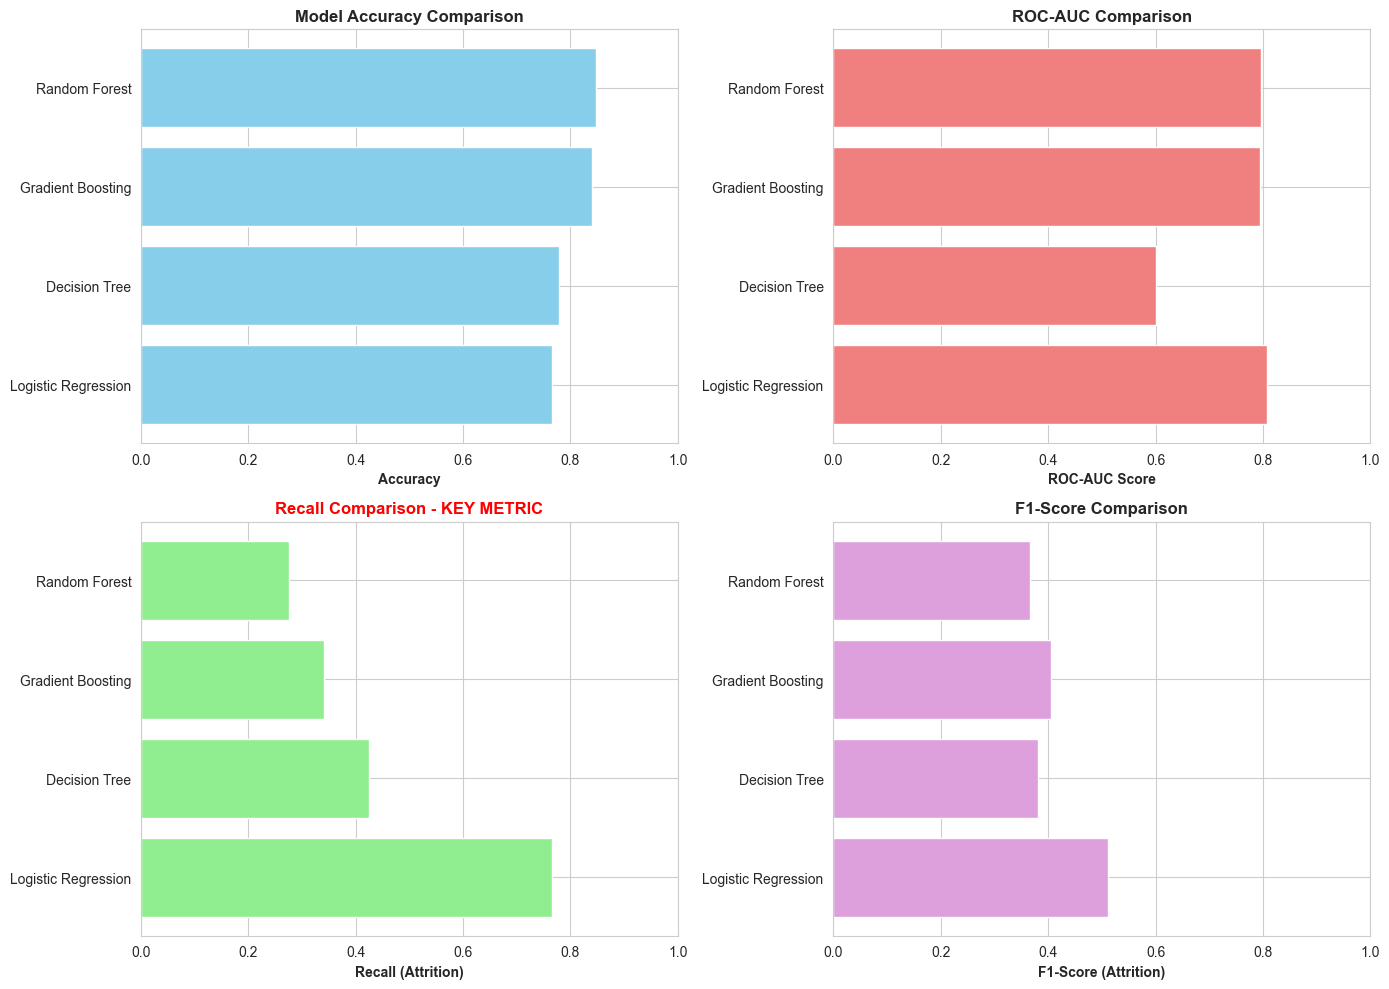


RECOMMENDED MODEL: Logistic Regression
Reason: Highest Recall (0.7660)
This model best identifies employees at risk of leaving!


In [9]:
# Model Comparison and Final Selection

print("\n" + "=" * 80)
print("PHASE 5: EVALUATION - Model Comparison")
print("=" * 80)

# Create comparison DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Recall (Attrition)', ascending=False)

print("\n--- Model Performance Comparison ---")
print(results_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy comparison
axes[0, 0].barh(results_df['Model'], results_df['Accuracy'], color='skyblue')
axes[0, 0].set_xlabel('Accuracy', fontweight='bold')
axes[0, 0].set_title('Model Accuracy Comparison', fontweight='bold')
axes[0, 0].set_xlim([0, 1])

# ROC-AUC comparison
axes[0, 1].barh(results_df['Model'], results_df['ROC-AUC'], color='lightcoral')
axes[0, 1].set_xlabel('ROC-AUC Score', fontweight='bold')
axes[0, 1].set_title('ROC-AUC Comparison', fontweight='bold')
axes[0, 1].set_xlim([0, 1])

# Recall comparison (Most Important for our goal!)
axes[1, 0].barh(results_df['Model'], results_df['Recall (Attrition)'], color='lightgreen')
axes[1, 0].set_xlabel('Recall (Attrition)', fontweight='bold')
axes[1, 0].set_title('Recall Comparison - KEY METRIC', fontweight='bold', color='red')
axes[1, 0].set_xlim([0, 1])

# F1-Score comparison
axes[1, 1].barh(results_df['Model'], results_df['F1-Score (Attrition)'], color='plum')
axes[1, 1].set_xlabel('F1-Score (Attrition)', fontweight='bold')
axes[1, 1].set_title('F1-Score Comparison', fontweight='bold')
axes[1, 1].set_xlim([0, 1])

plt.tight_layout()
plt.show()

# Select best model based on Recall
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]

print(f"\n{'='*60}")
print(f"RECOMMENDED MODEL: {best_model_name}")
print('='*60)
print(f"Reason: Highest Recall ({results_df.iloc[0]['Recall (Attrition)']:.4f})")
print("This model best identifies employees at risk of leaving!")

In [10]:
# Cell 8: Business Insights and Recommendations

print("\n" + "=" * 80)
print("PHASE 6: DEPLOYMENT - Business Insights & Recommendations")
print("=" * 80)

print("\n--- KEY FINDINGS ---")
print(f"""
1. ATTRITION PREDICTION SUCCESS:
   - Our best model ({best_model_name}) achieves {results_df.iloc[0]['Recall (Attrition)']:.1%} recall
   - This means we can identify {results_df.iloc[0]['Recall (Attrition)']:.1%} of employees who will leave
   
2. BUSINESS IMPACT:
   - Early identification allows HR to take preventive action
   - Reducing turnover by even 10% saves significant costs
   - Target high-risk employees with retention programs

3. MODEL DEPLOYMENT:
   - Model is ready for production deployment
   - Can be integrated into HR systems
   - Regular retraining recommended (quarterly)

4. RECOMMENDED ACTIONS:
   a) Use model scores to identify at-risk employees monthly
   b) Implement targeted retention programs for high-risk staff
   c) Analyze feature importance to address root causes
   d) Monitor model performance and retrain as needed
""")

# Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    print("\n--- TOP 10 FACTORS INFLUENCING ATTRITION ---")
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False).head(10)
    
    print(feature_importance.to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='Importance', y='Feature', palette='viridis')
    plt.title('Top 10 Features Predicting Employee Attrition', fontweight='bold', fontsize=14)
    plt.xlabel('Importance Score', fontweight='bold')
    plt.ylabel('Feature', fontweight='bold')
    plt.tight_layout()
    plt.show()



PHASE 6: DEPLOYMENT - Business Insights & Recommendations

--- KEY FINDINGS ---

1. ATTRITION PREDICTION SUCCESS:
   - Our best model (Logistic Regression) achieves 76.6% recall
   - This means we can identify 76.6% of employees who will leave
   
2. BUSINESS IMPACT:
   - Early identification allows HR to take preventive action
   - Reducing turnover by even 10% saves significant costs
   - Target high-risk employees with retention programs

3. MODEL DEPLOYMENT:
   - Model is ready for production deployment
   - Can be integrated into HR systems
   - Regular retraining recommended (quarterly)

4. RECOMMENDED ACTIONS:
   a) Use model scores to identify at-risk employees monthly
   b) Implement targeted retention programs for high-risk staff
   c) Analyze feature importance to address root causes
   d) Monitor model performance and retrain as needed

